**Librer√≠as**

In [1]:
import numpy as np
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

**Cargar el dataset**

In [2]:
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/PLN/PR√ÅCTICA FINAL/genero/"

Mounted at /content/drive


In [3]:
df = pd.read_csv(PATH+"politicES_phase_2_train_public.csv") 
print('dataset cargado:', df.shape)
df.head()

dataset cargado: (180000, 6)


label  gender  profession ideology_binary  \
0  0008c4fab9e97623a60380ee9c88cb20  female  politician            left   
1  0008c4fab9e97623a60380ee9c88cb20  female  politician            left   
2  0008c4fab9e97623a60380ee9c88cb20  female  politician            left   
3  0008c4fab9e97623a60380ee9c88cb20  female  politician            left   
4  0008c4fab9e97623a60380ee9c88cb20  female  politician            left   

  ideology_multiclass                                              tweet  
0                left  ¬°Feliz 28 de febrero a todas las andaluzas y a...  
1                left  Feliz a√±o nuevo, feliz esperanza üíï. Querido 20...  
2                left  üá©üá™üá™üá∏ ¬°Un placer encontrarme con mi hom√≥logo al...  
3                left  El conflicto en Ucrania ha supuesto una dram√°t...  
4                left  La Academia de la Llingua Asturiana realiza un...

**Para la clasificaci√≥n binaria me quedo solamente con los campos "tweet" y "gender"**

In [4]:
df_cb=df[['tweet', 'gender']].rename(columns={'tweet': 'text', 'gender': 'label'})
df_cb.head()

text   label
0  ¬°Feliz 28 de febrero a todas las andaluzas y a...  female
1  Feliz a√±o nuevo, feliz esperanza üíï. Querido 20...  female
2  üá©üá™üá™üá∏ ¬°Un placer encontrarme con mi hom√≥logo al...  female
3  El conflicto en Ucrania ha supuesto una dram√°t...  female
4  La Academia de la Llingua Asturiana realiza un...  female

**Crear particiones**

In [5]:
# quitar las siguientes 4 l√≠neas para coger todos los datos
parte_test = 0.6
df_train, df_aux = np.split(df_cb, [int((1 - parte_test) * len(df))])
X=df_train['text'] 
y=df_train['label']

#X=df_cb['text'] 
#y=df_cb['label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, 
        test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, 
        test_size=0.5, random_state=42, stratify=y_aux)

print('Tama√±o conjunto de entrenamiento:', len(X_train))
print('Tama√±o conjunto de validaci√≥n:', len(X_val))
print('Tama√±o conjunto de evaluaci√≥n:', len(X_test))

Tama√±o conjunto de entrenamiento: 50400
Tama√±o conjunto de validaci√≥n: 10800
Tama√±o conjunto de evaluaci√≥n: 10800


**Distribuci√≥n de las clases**

In [6]:
counts_train = y_train.value_counts().to_dict()
print("Distribuci√≥n en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribuci√≥n en validaci√≥n:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribuci√≥n en test:", counts_test)

LABELS=counts_train.keys()
print(LABELS)

Distribuci√≥n en training: {'male': 34440, 'female': 15960}
Distribuci√≥n en validaci√≥n: {'male': 7380, 'female': 3420}
Distribuci√≥n en test: {'male': 7380, 'female': 3420}
dict_keys(['male', 'female'])


Text(0, 0.5, 'N√∫mero de Instancias')

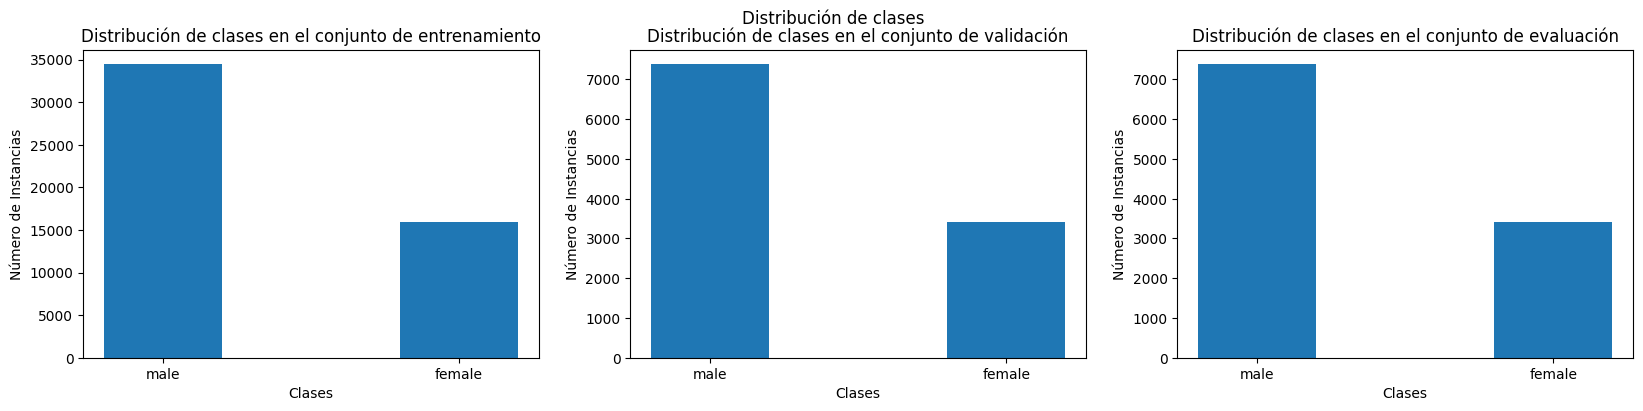

In [7]:
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribuci√≥n de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Distribuci√≥n de clases en el conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('N√∫mero de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Distribuci√≥n de clases en el conjunto de validaci√≥n')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('N√∫mero de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Distribuci√≥n de clases en el conjunto de evaluaci√≥n')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('N√∫mero de Instancias')

**Distribuci√≥n del tama√±o de los textos**

In [8]:
length_train=X_train.apply(lambda text: len(text.split()))
length_train.describe()

count    50400.000000
mean        28.774385
std         12.724002
min          4.000000
25%         17.000000
50%         28.000000
75%         40.000000
max         62.000000
Name: text, dtype: float64

In [9]:
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    50400.000000
mean        28.774385
std         12.724002
min          4.000000
25%         17.000000
50%         28.000000
75%         40.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         62.000000
Name: text, dtype: float64

In [10]:
length_val=X_val.apply(lambda text: len(text.split()))
length_val.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    10800.000000
mean        28.839630
std         12.761157
min          5.000000
25%         17.000000
50%         28.000000
75%         41.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         59.000000
Name: text, dtype: float64

In [11]:
length_test=X_test.apply(lambda text: len(text.split()))
length_test.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    10800.000000
mean        28.686574
std         12.814670
min          5.000000
25%         17.000000
50%         28.000000
75%         40.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         59.000000
Name: text, dtype: float64

Text(0, 0.5, 'N√∫mero de textos')

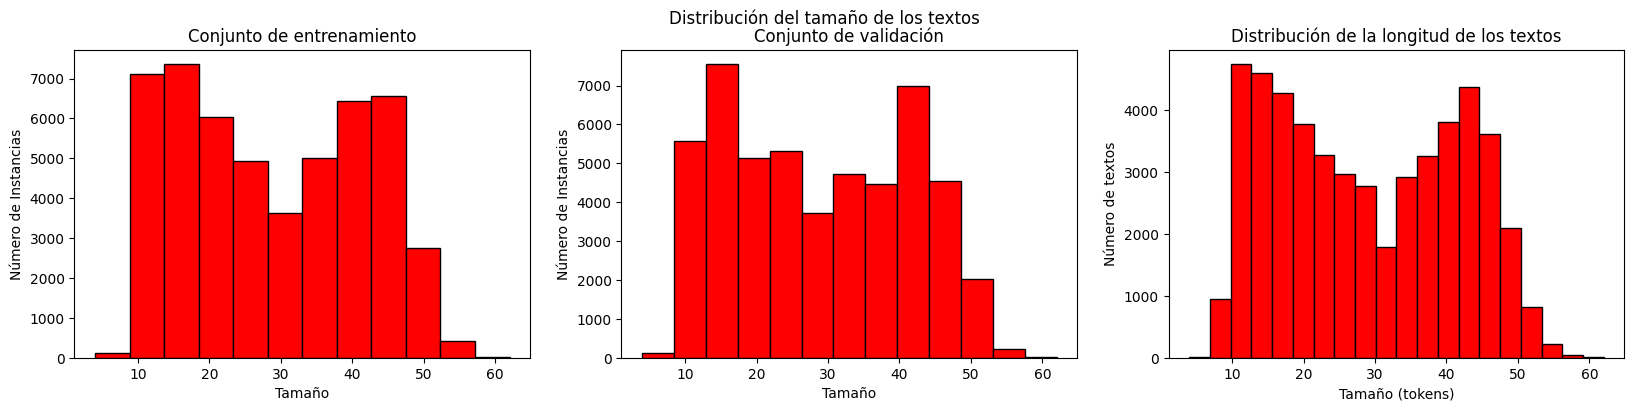

In [12]:
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribuci√≥n del tama√±o de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tama√±o')
ax_train.set_ylabel('N√∫mero de Instancias')

ax_val.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validaci√≥n')
ax_val.set_xlabel('Tama√±o')
ax_val.set_ylabel('N√∫mero de Instancias')

ax_test.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(300/15))
ax_test.set_title('Conjunto test')
ax_test.set_xlabel('Tama√±o')
ax_test.set_ylabel('N√∫mero de Instancias')

# Add labels
plt.title('Distribuci√≥n de la longitud de los textos')
plt.xlabel('Tama√±o (tokens)')
plt.ylabel('N√∫mero de textos')

**Representaci√≥n de textos**

La entrada del algoritmo de clasificaci√≥n son los textos, pero estos deben ser representados como vectores de n√∫meros reales. Antes de realizar esta transformaci√≥n, hay que incluir algunas tareas de limpieza de los textos, eliminando palabras y s√≠mbolos que no aporten informaci√≥n sem√°ntica para la clasificaci√≥n:

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

stopwords_es = stopwords.words("spanish")

def clean_text(text):
    # transformar a min√∫scula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 3 car√°ceres
    # ignoramos cualquier palabra que contenga un digito o un s√≠mbolo especial 
    min_length = 3
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)
            
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**tf-idf**

In [14]:
# entrenamos un modelo de bolsa de palabras
bow = CountVectorizer(analyzer=clean_text).fit(X_train)
# transformamos el conjunto de entrenamiento a bolsa de palabras
X_train_bow = bow.transform(X_train)
# transformamos el conjunto de evaluaci√≥n a bolsa de palabras
X_test_bow=bow.transform(X_test)


# entrenamos un modelo tf-idf 
tfidf_transformer = TfidfTransformer().fit(X_train_bow)
# transformamos el conjunto de entrenamiento
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
# transformamos el conjunto de entrenamiento
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

print('textos han sido representados con el modelo tf-idf ')

textos han sido representados con el modelo tf-idf 


In [15]:
print(X_train[0])
print(X_train_bow[0])
print(X_train_tfidf[0])

¬°Feliz 28 de febrero a todas las andaluzas y andaluces!. Por una Andaluc√≠a donde el presente, y el futuro, sea sin√≥nimo de derechos, de igualdad plena, de trabajo estable y con condiciones dignas. Una Andaluc√≠a de nuevas oportunidades, de esperanza.
  (0, 8014)	1
  (0, 9111)	1
  (0, 9549)	1
  (0, 9937)	1
  (0, 11682)	1
  (0, 19261)	1
  (0, 20852)	1
  (0, 30890)	1
  (0, 31785)	1
  (0, 32311)	1
  (0, 33781)	1
  (0, 34758)	1
  (0, 34894)	1
  (0, 35786)	1
  (0, 35840)	1
  (0, 37759)	1
  (0, 37883)	1
  (0, 39221)	1
  (0, 39221)	0.22070572749350004
  (0, 37883)	0.1385686376381328
  (0, 37759)	0.35268232978690306
  (0, 35840)	0.18776166543865944
  (0, 35786)	0.1704730687737294
  (0, 34894)	0.20794481720011354
  (0, 34758)	0.18640276983970921
  (0, 33781)	0.30877229388721705
  (0, 32311)	0.24828868932741993
  (0, 31785)	0.18918148388149542
  (0, 30890)	0.16602434178573044
  (0, 20852)	0.27268140173375244
  (0, 19261)	0.11057962904644296
  (0, 11682)	0.30877229388721705
  (0, 9937)	0.196960

**Clasificaci√≥n**

In [16]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  
    ('tf', TfidfTransformer()),  
    ('svm', SVC()), 
])

# Par√°metros para el algoritmo SVM
grid_params_svm = [{'svm__kernel': ['linear', 'rbf'], 
                    'svm__C': [0.1, 1], 
                    
                    }]  

  
gs = GridSearchCV(pipeline, param_grid=grid_params_svm, 
                  scoring='accuracy', cv=3, verbose = 1)

# entrenamos el grid
gs.fit(X_train, y_train)
print('Los mejores par√°metros son : %s' % gs.best_params_)
print('Mejor accuracy: %.3f' % gs.best_score_)
print(gs.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Los mejores par√°metros son : {'svm__C': 1, 'svm__kernel': 'rbf'}
Mejor accuracy: 0.706
Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function clean_text at 0x7fb14d33acb0>)),
                ('tf', TfidfTransformer()), ('svm', SVC(C=1))])


In [17]:
predictions = gs.predict(X_test)

In [18]:
print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

      female       0.67      0.16      0.26      3420
        male       0.71      0.96      0.82      7380

    accuracy                           0.71     10800
   macro avg       0.69      0.56      0.54     10800
weighted avg       0.70      0.71      0.64     10800



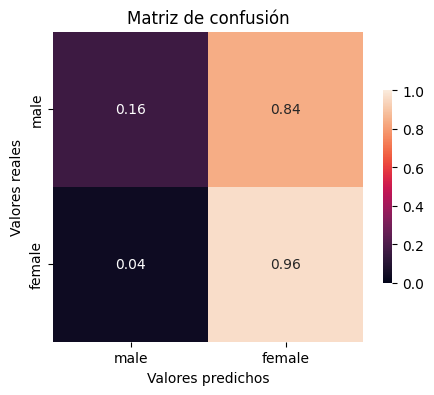

In [19]:
binary_labels = ["male", "female"]
fig = plt.subplots(figsize = (5, 5))
cm_dtc1 = confusion_matrix(y_test, predictions, normalize = "true")
sb.heatmap(cm_dtc1, vmin = 0, vmax = 1, square = True, annot = True, fmt = ".2f", cbar_kws = {"shrink" : 0.5}, xticklabels = binary_labels, yticklabels = binary_labels)
plt.title("Matriz de confusi√≥n")
plt.xlabel("Valores predichos")
plt.ylabel("Valores reales")
plt.show()

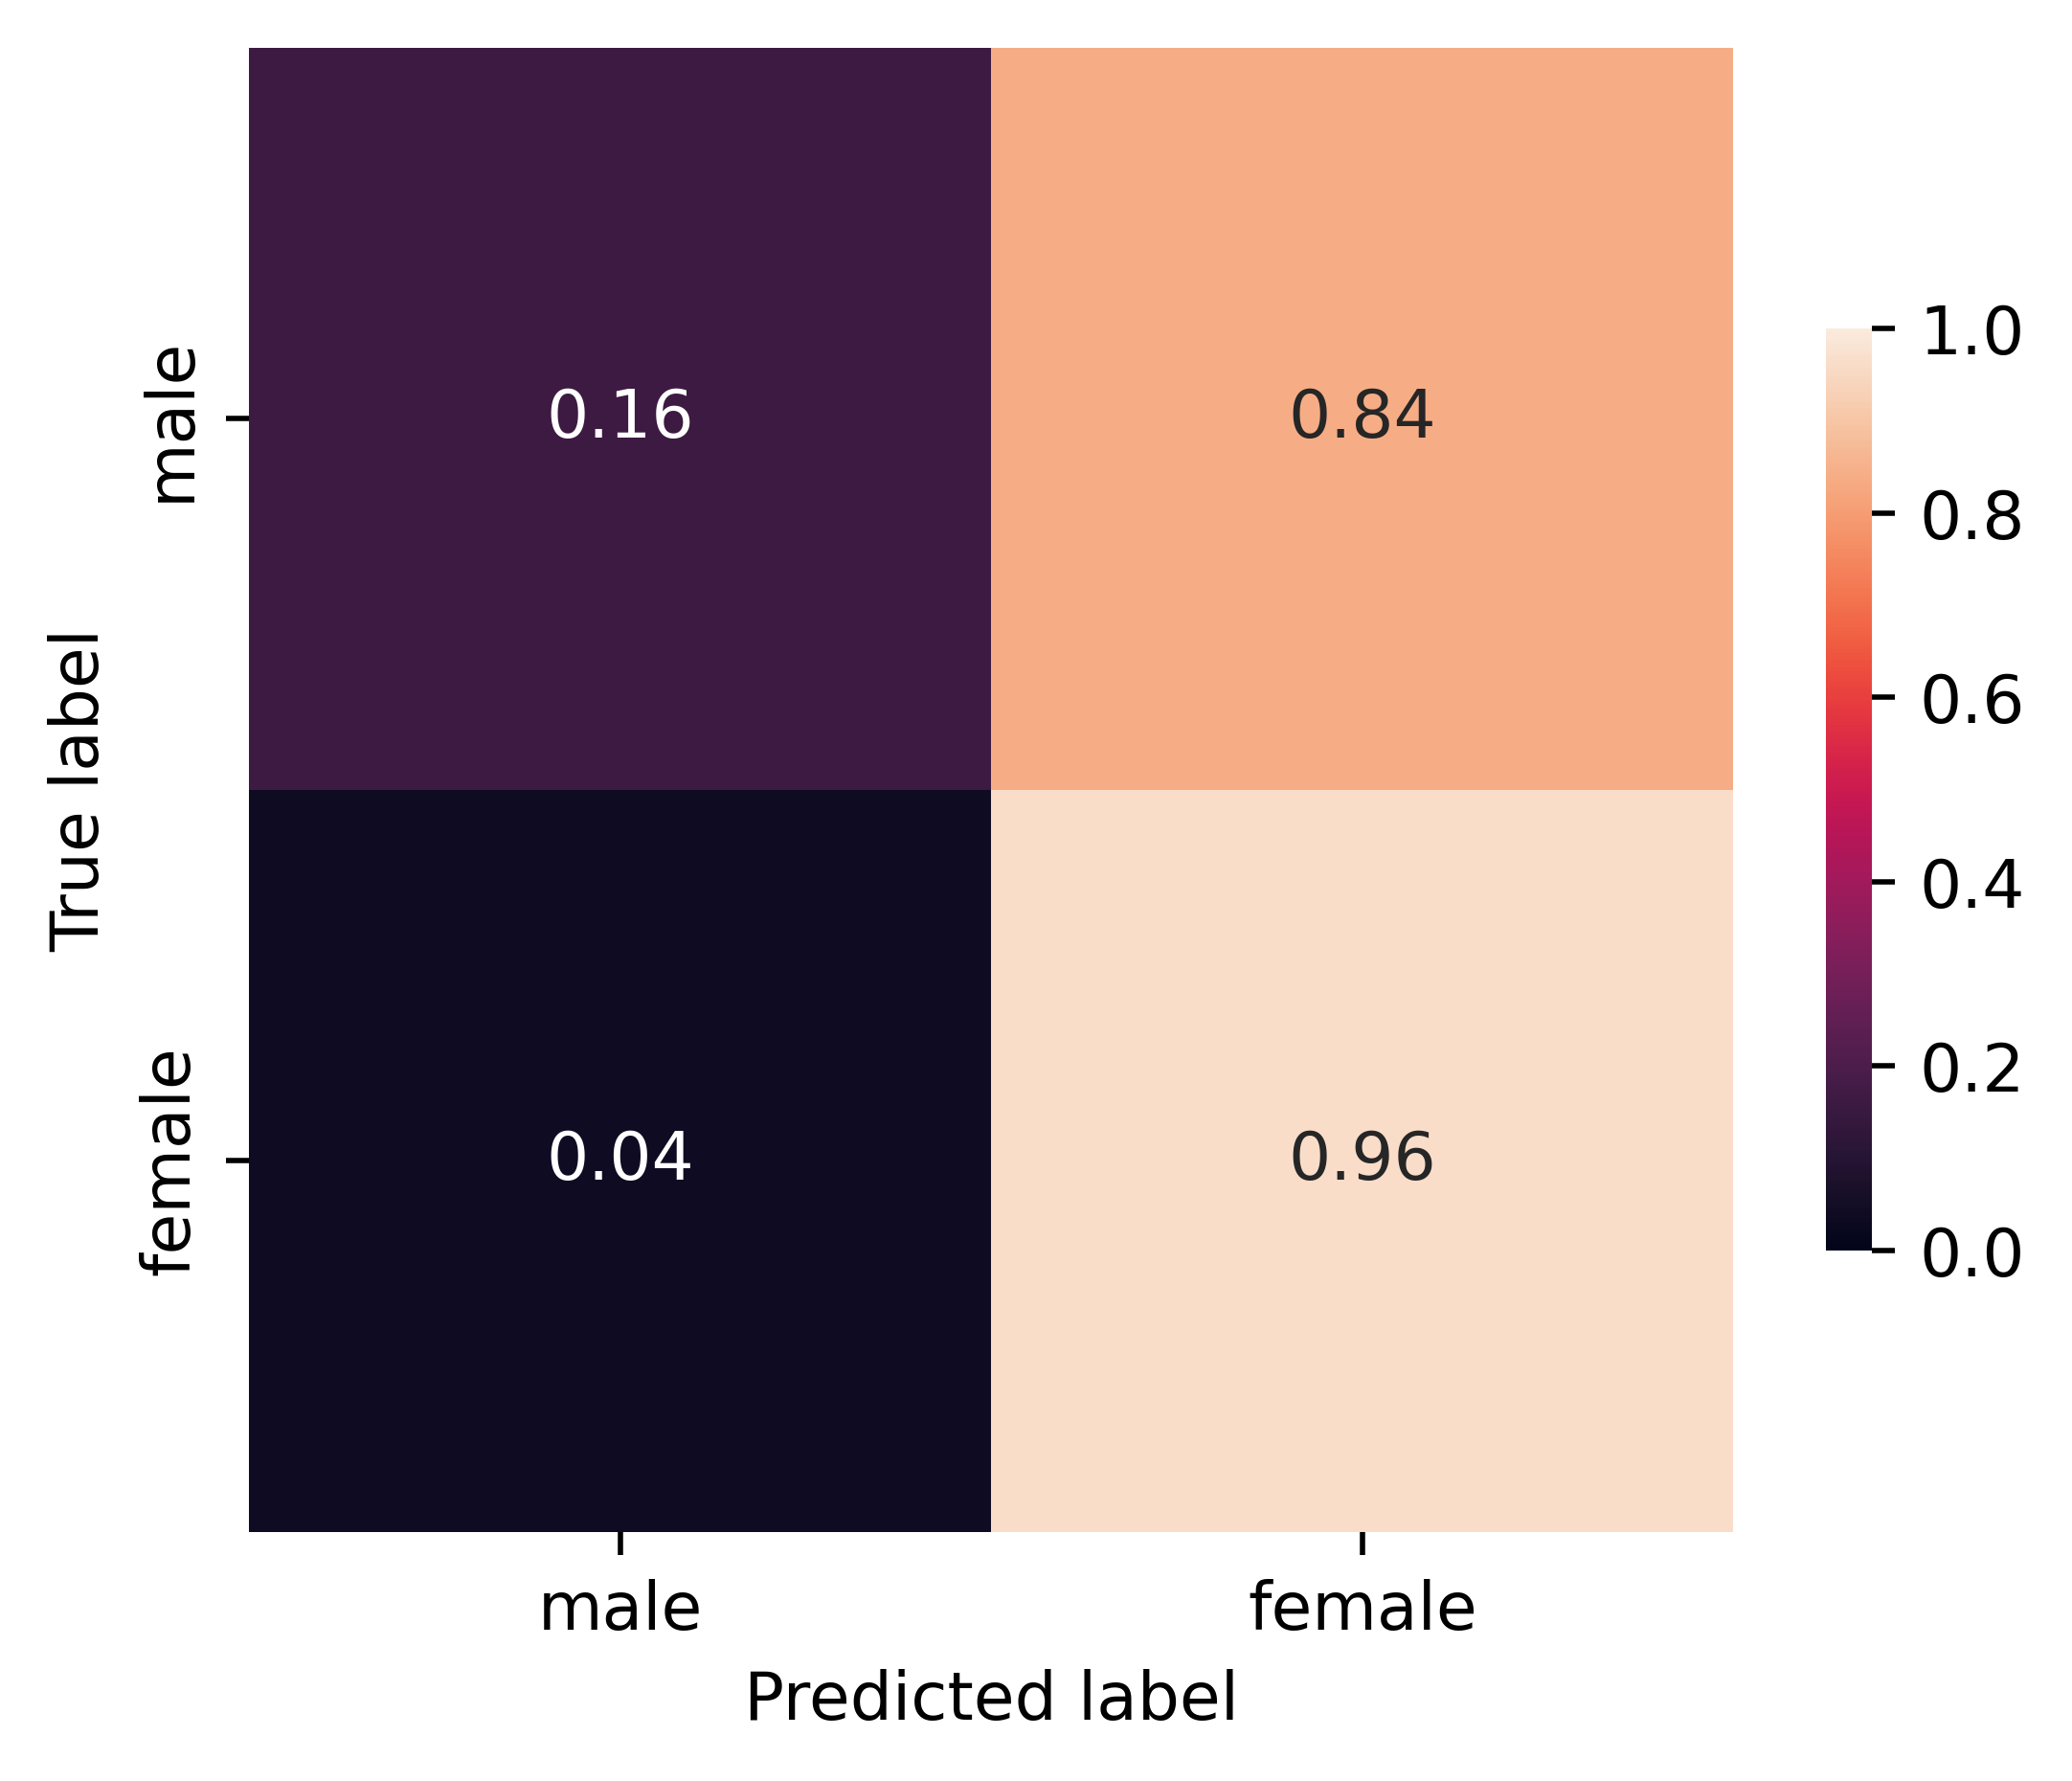

In [20]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
binary_labels = ["male", "female"]
fig, ax = plt.subplots(figsize=(5, 5), dpi=500)
cm_dtc1 = confusion_matrix(y_test, predictions, normalize="true")
sb.heatmap(cm_dtc1, vmin=0, vmax=1, square=True, annot=True, fmt=".2f", cbar_kws={"shrink": 0.5}, xticklabels=binary_labels, yticklabels=binary_labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("confusion_matrix.png", dpi=600)
plt.show()

a√±adir lo de noly
preguntar a chat gpt  pq falla el modelo al clasificar

In [21]:
type(y_test)
#for indice, valor in y_test.items():
#    print(indice, valor)
y_test2=np.array(y_test)

In [22]:
# Step 4: Analyze incorrect predictions

incorrect_indices = [i for i in range(len(y_test2)) if y_test2[i] != predictions[i]]
incorrect_samples = [df_cb.iloc[i]['text'] for i in incorrect_indices]
incorrect_true_labels = [y_test2[i] for i in incorrect_indices]
incorrect_predicted_labels = [predictions[i] for i in incorrect_indices]


c = 0
# Step 5: Investigate the misclassified samples
for sample, true_label, predicted_label in zip(incorrect_samples, incorrect_true_labels, incorrect_predicted_labels):
    # Analyze the misclassified sample and relevant information
    print(f'Sample: {sample}')
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')
    print("---")
    c = c + 1

Streaming output truncated to the last 5000 lines.
Sample: Pero qu√© maravilla. Sol en capricornio, luna en leo y ascendente en sagitario y me encanta todo ‚ú®
True Label: female
Predicted Label: male
---
Sample: Esto tiene que ser una broma, por favor que alguien desmienta esto porque se van a cargar el retiro
True Label: female
Predicted Label: male
---
Sample: @user Gracias a los vecinos y vecinas que particip√°is por apoyar al peque√±o comercio de nuestra ciudad! üòâüí™
True Label: female
Predicted Label: male
---
Sample: Ayer fue la justicia brit√°nica con el Em√©rito, deneg√°ndole la inmunidad. Hoy la justicia europea con el hermano de [POLITICIAN] y sus contratos y comisiones oscuras.. A ver si este a√±o no va a haber ‚Äúninots indultats‚Äù.
True Label: female
Predicted Label: male
---
Sample: @user üéô Este logro es de toda la sociedad valenciana. Recordamos hoy a quienes al final de la dictadura franquista lucharon para que hoy podamos disfrutar del Saler, la Albufera y el 